In [1]:
# 예측 결과 데이터 불러오기
import pandas as pd

kospi_result = pd.read_csv("kospi_result.csv", index_col = 0)
sp500_result = pd.read_csv("sp500_result.csv", index_col = 0)
euro_result = pd.read_csv("euro_result.csv", index_col = 0)
wti_result = pd.read_csv("wti_result.csv", index_col = 0)
csi300_result = pd.read_csv("csi300_result.csv", index_col = 0)
kosdaq150_result = pd.read_csv("kosdaq150_result.csv", index_col = 0)

In [2]:
# datetime 형태로 변환
kospi_result["date"] = pd.to_datetime(kospi_result["date"])
sp500_result["date"] = pd.to_datetime(sp500_result["date"])
euro_result["date"] = pd.to_datetime(euro_result["date"])
wti_result["date"] = pd.to_datetime(wti_result["date"])
csi300_result["date"] = pd.to_datetime(csi300_result["date"])
kosdaq150_result["date"] = pd.to_datetime(kosdaq150_result["date"])

### 안전자산 데이터

In [3]:
# 국고채 10년 ETF 데이터
import FinanceDataReader as fdr

bond_10y_etf = fdr.DataReader("148070", "2010-01-01")
bond_10y_etf = bond_10y_etf.reset_index()
bond_10y_etf.columns = ["date", "open", "high", "low", "close", "volume", "change"]
bond_10y_etf.head()

,date,open,high,low,close,volume,change
0,2011-10-20,83795,83904,83771,83860,43093,NaN
1,2011-10-21,83724,83779,83346,83487,4286,-0.004448
2,2011-10-24,83509,83509,83167,83199,4303,-0.003450
3,2011-10-25,83321,83439,83276,83363,1186,0.001971
4,2011-10-26,83305,83498,83221,83484,17543,0.001451


In [4]:
# 골드 ETF 데이터
import FinanceDataReader as fdr

gold_etf = fdr.DataReader("132030", "2010-01-01")
gold_etf = gold_etf.reset_index()
gold_etf.columns = ["date", "open", "high", "low", "close", "volume", "change"]
gold_etf.head()

,date,open,high,low,close,volume,change
0,2010-10-01,9980,10005,9980,9995,53631,NaN
1,2010-10-04,10055,10065,10040,10065,67972,0.007004
2,2010-10-05,10040,10065,10020,10065,13891,0.000000
3,2010-10-06,10225,10295,10220,10285,12205,0.021858
4,2010-10-07,10270,10340,10260,10335,17231,0.004861


In [5]:
# 달러 ETF 데이터
import FinanceDataReader as fdr

dollar_etf = fdr.DataReader("138230", "2010-01-01")
dollar_etf = dollar_etf.reset_index()
dollar_etf.columns = ["date", "open", "high", "low", "close", "volume", "change"]
dollar_etf.head()

,date,open,high,low,close,volume,change
0,2011-02-24,11069,11089,11017,11090,12591,NaN
1,2011-02-25,11069,11079,11039,11051,3619,-0.003517
2,2011-02-28,11069,11096,11039,11073,3775,0.001991
3,2011-03-02,11069,11079,11051,11073,4788,0.000000
4,2011-03-03,11060,11060,10994,10997,1838,-0.006864


In [6]:
# VAA Score
def vaa_score(df):
    df["close_1y_lag"] = df["close"].shift(252)
    df["close_6m_lag"] = df["close"].shift(121)
    df["close_3m_lag"] = df["close"].shift(60)
    df["close_1m_lag"] = df["close"].shift(20)
    
    df["momentum_1y"] = (df["close"] - df["close_1y_lag"]) - 1
    df["momentum_6m"] = (df["close"] - df["close_6m_lag"]) - 1
    df["momentum_3m"] = (df["close"] - df["close_3m_lag"]) - 1
    df["momentum_1m"] = (df["close"] - df["close_1m_lag"]) - 1
    
    df["vaa_score"] = (12 * df["momentum_1m"]) + (4 * df["momentum_3m"]) + (2 * df["momentum_6m"]) + (1 * df["momentum_1y"])
    
    return df

In [7]:
# 안전자산 date, change, vaa_score 형태로
def clean(df, standard):
    df_vaa = vaa_score(df)
    df_vaa = df_vaa[df_vaa["date"] >= "2018-01-01"][["date", "change", "vaa_score"]].reset_index(drop = True)
    df_vaa = pd.merge(df_vaa, standard["date"], on = "date", how = "inner")
    
    return df_vaa

bond_10y_result = clean(bond_10y_etf, kospi_result)
gold_result = clean(gold_etf, kospi_result)
dollar_result = clean(dollar_etf, kospi_result)

### EMP 백테스팅

In [8]:
# 각 자산별 투자 비중
weight = pd.DataFrame(columns = ["kodex200", "sp500", "euro_stoxx50", "wti", "csi300", "kosdaq150", "bond_10y", "gold", "dollar"])

for i in range(0, len(kospi_result)):
    
    # 위험자산의 predict가 모두 0일 때, 안전자산 중 VAA Score가 가장 높은 자산에 비중 100% 투자
    if (kospi_result["predict"][i] == 0) and (sp500_result["predict"][i] == 0) and (euro_result["predict"][i] == 0) and (wti_result["predict"][i] == 0) and (csi300_result["predict"][i] == 0) and (kosdaq150_result["predict"][i] == 0):
        riskless = [bond_10y_result["vaa_score"][i], gold_result["vaa_score"][i], dollar_result["vaa_score"][i]]
        loc = riskless.index(max(riskless))
        
        weight_list = [0 for zero in range(0, 9)]
        weight_list[loc + 6] = 1
        weight.loc[i] = weight_list
    
    else:
        # predict = 1인 자산 추출
        pred_list = [kospi_result["predict"][i], sp500_result["predict"][i], euro_result["predict"][i], wti_result["predict"][i], csi300_result["predict"][i], kosdaq150_result["predict"][i]]
        pred_loc = []
        for j in range(0, 6):
            if pred_list[j] == 1:
                pred_loc.append(j)
        
        vaa_list = [kospi_result["vaa_score"][i], sp500_result["vaa_score"][i], euro_result["vaa_score"][i], wti_result["vaa_score"][i], csi300_result["vaa_score"][i], kosdaq150_result["vaa_score"][i]]
        plus_list = []
        for loc in pred_loc:
            if vaa_list[loc] >= 0:
                plus_list.append(loc)
        
        # 위험자산의 predict가 1인 자산들 중 VAA Score가 모두 음수라면, 위험자산에 동일 가중으로 투자
        if sum(plus_list) == 0:
            weight.loc[i] = [1/6, 1/6, 1/6, 1/6, 1/6, 1/6, 0, 0, 0]
            
        # 위험자산의 predict가 1인 자산들 중 VAA Score가 양수인 위험 자산에 VAA Score 가중치에 따른 비중으로 투자
        else:
            
            # predict = 1인 자산의 VAA Score 합
            vaa_sum = 0
            for k in plus_list:
                vaa_sum = vaa_sum + vaa_list[k]
                
            # predict = 1인 자산의 VAA Score 비중에 따른 투자 비중
            vaa_weight = []
            for k in plus_list:
                ind_weight = vaa_list[k] / vaa_sum
                vaa_weight.append(ind_weight)
                
            weight_list = [0 for zero in range(0, 9)]
            for l in range(0, len(plus_list)):
                weight_list[pred_loc[l]] = vaa_weight[l]
        
            weight.loc[i] = weight_list
            
weight

,kodex200,sp500,euro_stoxx50,wti,csi300,kosdaq150,bond_10y,gold,dollar
0,0.000000,0.389649,0.000000,0.000000,0.067065,0.543286,0.0,0.0,0.0
1,0.000000,0.387347,0.000000,0.000000,0.072689,0.539964,0.0,0.0,0.0
2,0.000000,0.421318,0.000000,0.000000,0.071175,0.507507,0.0,0.0,0.0
3,0.000000,0.396202,0.000000,0.000000,0.075396,0.528402,0.0,0.0,0.0
4,0.000000,0.378743,0.000000,0.000000,0.070806,0.550451,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
736,0.569450,0.242355,0.045195,0.008042,0.000000,0.134957,0.0,0.0,0.0
737,0.573244,0.248307,0.048207,0.009826,0.000000,0.120416,0.0,0.0,0.0
738,0.571468,0.249395,0.050768,0.010981,0.000000,0.117388,0.0,0.0,0.0
739,0.566896,0.248181,0.049477,0.014988,0.000000,0.120458,0.0,0.0,0.0


In [55]:
# EMP 포트폴리오의 매 기 별 수익률 산출 (매매수수료 포함)

weighted_return = []
sp500_daily_return = []
euro_stoxx50_daily_return = []
wti_daily_return = []
csi300_daily_return = []
bond_10y_daily_return = []
gold_daily_return = []
dollar_daily_return = []
for i in range(0, len(weight) - 1):
    
    if i == 0:
        # 위험 자산
        weighted_kodex200 = weight["kodex200"][i] * (kospi_result["change"][i+1] - 0.00015)
        weighted_sp500 = weight["sp500"][i] * (sp500_result["change"][i+1] - 0.00015)
        weighted_euro_stoxx50 = weight["euro_stoxx50"][i] * (euro_result["change"][i+1] - 0.00015)
        weighted_wti = weight["wti"][i] * (wti_result["change"][i+1] - 0.00015)
        weighted_csi300 = weight["csi300"][i] * (csi300_result["change"][i+1] - 0.00015)
        weighted_kosdaq150 = weight["kosdaq150"][i] * (kosdaq150_result["change"][i+1] - 0.00015)
        
        # 안전 자산
        weighted_bond_10y = weight["bond_10y"][i] * (bond_10y_result["change"][i+1] - 0.00015)
        weighted_gold = weight["gold"][i] * (gold_result["change"][i+1] - 0.00015)
        weighted_dollar = weight["dollar"][i] * (dollar_result["change"][i+1] - 0.00015)
                                                 
    else:
        # 위험 자산
        weighted_kodex200 = weight["kodex200"][i] * kospi_result["change"][i+1] - (abs(weight["kodex200"][i] - weight["kodex200"][i-1]) * 0.00015)
        weighted_sp500 = weight["sp500"][i] * sp500_result["change"][i+1] - (abs(weight["sp500"][i] - weight["sp500"][i-1]) * 0.00015)
        weighted_euro_stoxx50 = weight["euro_stoxx50"][i] * euro_result["change"][i+1] - (abs(weight["euro_stoxx50"][i] - weight["euro_stoxx50"][i-1]) * 0.00015)
        weighted_wti = weight["wti"][i] * wti_result["change"][i+1] - (abs(weight["wti"][i] - weight["wti"][i-1]) * 0.00015)
        weighted_csi300 = weight["csi300"][i] * csi300_result["change"][i+1] - (abs(weight["csi300"][i] - weight["csi300"][i-1]) * 0.00015)
        weighted_kosdaq150 = weight["kosdaq150"][i] * kosdaq150_result["change"][i+1] - (abs(weight["kosdaq150"][i] - weight["kosdaq150"][i-1]) * 0.00015)

        # 안전 자산
        weighted_bond_10y = weight["bond_10y"][i] * bond_10y_result["change"][i+1] - (abs(weight["bond_10y"][i] - weight["bond_10y"][i-1]) * 0.00015)
        weighted_gold = weight["gold"][i] * gold_result["change"][i+1] - (abs(weight["gold"][i] - weight["gold"][i-1]) * 0.00015)
        weighted_dollar = weight["dollar"][i] * dollar_result["change"][i+1] - (abs(weight["dollar"][i] - weight["dollar"][i-1]) * 0.00015)
    
    # 매 기 별 수익률
    ind_return = 1 + (weighted_kodex200 + weighted_sp500 + weighted_euro_stoxx50 + weighted_wti + weighted_csi300 + weighted_kosdaq150 + weighted_bond_10y + weighted_gold + weighted_dollar)
    weighted_return.append(ind_return)
    sp500_daily_return.append(1 + weighted_sp500)
    euro_stoxx50_daily_return.append(1 + weighted_euro_stoxx50)
    wti_daily_return.append(1 + weighted_wti)
    csi300_daily_return.append(1 + weighted_csi300)
    bond_10y_daily_return.append(1 + weighted_bond_10y)
    gold_daily_return.append(1 + weighted_gold)
    dollar_daily_return.append(1 + weighted_dollar)
    
emp_result = weight[:740].copy()
emp_result.insert(0, "date", kospi_result["date"][:740])
emp_result["return"] = weighted_return

emp_result

,date,kodex200,sp500,euro_stoxx50,wti,csi300,kosdaq150,bond_10y,gold,dollar,return
0,2018-01-02,0.000000,0.389649,0.000000,0.000000,0.067065,0.543286,0.0,0.0,0.0,1.011947
1,2018-01-03,0.000000,0.387347,0.000000,0.000000,0.072689,0.539964,0.0,0.0,0.0,0.987603
2,2018-01-04,0.000000,0.421318,0.000000,0.000000,0.071175,0.507507,0.0,0.0,0.0,1.021964
3,2018-01-05,0.000000,0.396202,0.000000,0.000000,0.075396,0.528402,0.0,0.0,0.0,1.017157
4,2018-01-08,0.000000,0.378743,0.000000,0.000000,0.070806,0.550451,0.0,0.0,0.0,0.997399
...,...,...,...,...,...,...,...,...,...,...,...
735,2021-01-29,0.540150,0.273464,0.062897,0.009495,0.000000,0.113994,0.0,0.0,0.0,1.015781
736,2021-02-01,0.569450,0.242355,0.045195,0.008042,0.000000,0.134957,0.0,0.0,0.0,1.013821
737,2021-02-02,0.573244,0.248307,0.048207,0.009826,0.000000,0.120416,0.0,0.0,0.0,1.009735
738,2021-02-03,0.571468,0.249395,0.050768,0.010981,0.000000,0.117388,0.0,0.0,0.0,0.988191


In [56]:
# 각 자산 별 누적 수익률
def asset_cum_return(daily_return, df, asset):
    new_asset = 1
    cum_return = []
    asset_value = []
    
    for i in range(0, len(daily_return)):
        if df[asset][i] == 0:
            new_asset = 1
            cum_r = (new_asset - 1) * 100
            
        else:
            new_asset = new_asset * daily_return[i]
            cum_r = (new_asset - 1) * 100
        
        cum_return.append(cum_r)
        asset_value.append(new_asset)
        
    return asset_value

In [57]:
# tax cost 산출
def tax(df, asset, cum_return):
    tax_list = []
    for i in range(1, len(df)):
        if (df[asset][i] < df[asset][i-1]) and ((cum_return[i-1] - 1) > 0):
            tax_cost = abs(df[asset][i] - df[asset][i-1]) * (cum_return[i-1] - 1) * 0.154
            
        else:
            tax_cost = 0
            
        tax_list.append(tax_cost)
    
    tax_list.append(0)
        
    return tax_list

In [58]:
# 각 자산의 tax cost를 매 기의 return에서 차감
df_tax = pd.DataFrame()
df_tax["sp500_tax"] = tax(emp_result, "sp500", asset_cum_return(sp500_daily_return, emp_result, "sp500"))
df_tax["euro_stoxx50_tax"] = tax(emp_result, "euro_stoxx50", asset_cum_return(euro_stoxx50_daily_return, emp_result, "euro_stoxx50"))
df_tax["wti_tax"] = tax(emp_result, "wti", asset_cum_return(wti_daily_return, emp_result, "wti"))
df_tax["csi300_tax"] = tax(emp_result, "csi300", asset_cum_return(csi300_daily_return, emp_result, "csi300"))
df_tax["bond_10y_tax"] = tax(emp_result, "bond_10y", asset_cum_return(bond_10y_daily_return, emp_result, "bond_10y"))
df_tax["gold_tax"] = tax(emp_result, "gold", asset_cum_return(gold_daily_return, emp_result, "gold"))
df_tax["dollar_tax"] = tax(emp_result, "dollar", asset_cum_return(dollar_daily_return, emp_result, "dollar"))

df_tax["all_tax"] = df_tax["sp500_tax"] + df_tax["euro_stoxx50_tax"] + df_tax["wti_tax"] + df_tax["csi300_tax"] + df_tax["bond_10y_tax"] + df_tax["gold_tax"] + df_tax["dollar_tax"]

emp_result["adj_return"] = emp_result["return"] - df_tax["all_tax"]
emp_result

,date,kodex200,sp500,euro_stoxx50,wti,csi300,kosdaq150,bond_10y,gold,dollar,return,adj_return
0,2018-01-02,0.000000,0.389649,0.000000,0.000000,0.067065,0.543286,0.0,0.0,0.0,1.011947,1.011946
1,2018-01-03,0.000000,0.387347,0.000000,0.000000,0.072689,0.539964,0.0,0.0,0.0,0.987603,0.987603
2,2018-01-04,0.000000,0.421318,0.000000,0.000000,0.071175,0.507507,0.0,0.0,0.0,1.021964,1.021936
3,2018-01-05,0.000000,0.396202,0.000000,0.000000,0.075396,0.528402,0.0,0.0,0.0,1.017157,1.017130
4,2018-01-08,0.000000,0.378743,0.000000,0.000000,0.070806,0.550451,0.0,0.0,0.0,0.997399,0.997398
...,...,...,...,...,...,...,...,...,...,...,...,...
735,2021-01-29,0.540150,0.273464,0.062897,0.009495,0.000000,0.113994,0.0,0.0,0.0,1.015781,1.015361
736,2021-02-01,0.569450,0.242355,0.045195,0.008042,0.000000,0.134957,0.0,0.0,0.0,1.013821,1.013821
737,2021-02-02,0.573244,0.248307,0.048207,0.009826,0.000000,0.120416,0.0,0.0,0.0,1.009735,1.009735
738,2021-02-03,0.571468,0.249395,0.050768,0.010981,0.000000,0.117388,0.0,0.0,0.0,0.988191,0.988171


In [59]:
# 누적 포트폴리오 수익률
new_asset = 1
cum_return = []
asset_value = []

for i in range(0, len(emp_result)):
    new_asset = new_asset * emp_result["adj_return"][i]
    cum_r = (new_asset - 1) * 100
    
    cum_return.append(cum_r)
    asset_value.append(new_asset)

emp_result["cum_return(%)"] = cum_return
emp_result["asset_value"] = asset_value

emp_result

,date,kodex200,sp500,euro_stoxx50,wti,csi300,kosdaq150,bond_10y,gold,dollar,return,adj_return,cum_return(%),asset_value
0,2018-01-02,0.000000,0.389649,0.000000,0.000000,0.067065,0.543286,0.0,0.0,0.0,1.011947,1.011946,1.194650,1.011946
1,2018-01-03,0.000000,0.387347,0.000000,0.000000,0.072689,0.539964,0.0,0.0,0.0,0.987603,0.987603,-0.059841,0.999402
2,2018-01-04,0.000000,0.421318,0.000000,0.000000,0.071175,0.507507,0.0,0.0,0.0,1.021964,1.021936,2.132478,1.021325
3,2018-01-05,0.000000,0.396202,0.000000,0.000000,0.075396,0.528402,0.0,0.0,0.0,1.017157,1.017130,3.882019,1.038820
4,2018-01-08,0.000000,0.378743,0.000000,0.000000,0.070806,0.550451,0.0,0.0,0.0,0.997399,0.997398,3.611680,1.036117
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
735,2021-01-29,0.540150,0.273464,0.062897,0.009495,0.000000,0.113994,0.0,0.0,0.0,1.015781,1.015361,13.088246,1.130882
736,2021-02-01,0.569450,0.242355,0.045195,0.008042,0.000000,0.134957,0.0,0.0,0.0,1.013821,1.013821,14.651267,1.146513
737,2021-02-02,0.573244,0.248307,0.048207,0.009826,0.000000,0.120416,0.0,0.0,0.0,1.009735,1.009735,15.767390,1.157674
738,2021-02-03,0.571468,0.249395,0.050768,0.010981,0.000000,0.117388,0.0,0.0,0.0,0.988191,0.988171,14.397950,1.143980


In [60]:
# EMP 포트폴리오 성과 지표
import numpy as np

def portfolio_report(df):
    pf_report = pd.DataFrame()
    
    # MDD
    arr_v = np.array(df["asset_value"])
    peak_lower = np.argmax(np.maximum.accumulate(arr_v) - arr_v)
    peak_upper = np.argmax(arr_v[:peak_lower])
    mdd = (arr_v[peak_lower] - arr_v[peak_upper]) / arr_v[peak_upper]
    
    # CAGR
    diff = df["date"].iloc[-1] - df["date"].iloc[0]
    N = diff.days / 365
    cum = (1 + (df["cum_return(%)"][739] * 0.01))
    CAGR = (cum**(1/N)) - 1
    
    # Sharp ratio ((CAGR - rf) / vol_year) : 표준편차 => 약 3년 간의 daily return * sqrt(252)
    std = np.std(df["return"]) * np.sqrt(252)
    rf = 0.03
    SR = (CAGR - rf) / std
    
    pf_report["cum_return"] = [round(df["cum_return(%)"][739], 2)]
    pf_report["CAGR"] = round(CAGR * 100, 3)
    pf_report["MDD"] = round(mdd * 100, 3)
    pf_report["SR"] = round(SR, 3)
    pf_report["Std"] = round(std, 3)

    return pf_report

In [179]:
emp_report = portfolio_report(emp_result).T
emp_report

,0
cum_return,15.780
CAGR,4.850
MDD,-36.651
SR,0.093
Std,0.199


### 동일 가중 포트폴리오

In [91]:
# 동일 가중 포트폴리오의 매 기 별 수익률 산출 (매매수수료 포함)
equal_weight = pd.DataFrame(columns = ["kodex200", "sp500", "euro_stoxx50", "wti", "csi300", "kosdaq150", "bond_10y", "gold", "dollar"])
for i in range(0, 741):
    equal_weight.loc[i] = [1/6, 1/6, 1/6, 1/6, 1/6, 1/6, 0, 0, 0]
#     [1/9 for w in range(0, 9)]

equal_weighted_return = []
equal_sp500_daily_return = []
equal_euro_stoxx50_daily_return = []
equal_wti_daily_return = []
equal_csi300_daily_return = []
equal_bond_10y_daily_return = []
equal_gold_daily_return = []
equal_dollar_daily_return = []
for i in range(0, len(equal_weight) - 1):
    
    if i == 0:
        # 위험 자산
        equal_weighted_kodex200 = equal_weight["kodex200"][i] * (kospi_result["change"][i+1] - 0.00015)
        equal_weighted_sp500 = equal_weight["sp500"][i] * (sp500_result["change"][i+1] - 0.00015)
        equal_weighted_euro_stoxx50 = equal_weight["euro_stoxx50"][i] * (euro_result["change"][i+1] - 0.00015)
        equal_weighted_wti = equal_weight["wti"][i] * (wti_result["change"][i+1] - 0.00015)
        equal_weighted_csi300 = equal_weight["csi300"][i] * (csi300_result["change"][i+1] - 0.00015)
        equal_weighted_kosdaq150 = equal_weight["kosdaq150"][i] * (kosdaq150_result["change"][i+1] - 0.00015)
        
        # 안전 자산
        equal_weighted_bond_10y = equal_weight["bond_10y"][i] * (bond_10y_result["change"][i+1] - 0.00015)
        equal_weighted_gold = equal_weight["gold"][i] * (gold_result["change"][i+1] - 0.00015)
        equal_weighted_dollar = equal_weight["dollar"][i] * (dollar_result["change"][i+1] - 0.00015)
        
    else:
        # 위험 자산
        equal_weighted_kodex200 = equal_weight["kodex200"][i] * kospi_result["change"][i+1] - (abs(equal_weight["kodex200"][i] - equal_weight["kodex200"][i-1]) * 0.00015)
        equal_weighted_sp500 = equal_weight["sp500"][i] * sp500_result["change"][i+1] - (abs(equal_weight["sp500"][i] - equal_weight["sp500"][i-1]) * 0.00015)
        equal_weighted_euro_stoxx50 = equal_weight["euro_stoxx50"][i] * euro_result["change"][i+1] - (abs(equal_weight["euro_stoxx50"][i] - equal_weight["euro_stoxx50"][i-1]) * 0.00015)
        equal_weighted_wti = equal_weight["wti"][i] * wti_result["change"][i+1] - (abs(equal_weight["wti"][i] - equal_weight["wti"][i-1]) * 0.00015)
        equal_weighted_csi300 = equal_weight["csi300"][i] * csi300_result["change"][i+1] - (abs(equal_weight["csi300"][i] - equal_weight["csi300"][i-1]) * 0.00015)
        equal_weighted_kosdaq150 = equal_weight["kosdaq150"][i] * kosdaq150_result["change"][i+1] - (abs(equal_weight["kosdaq150"][i] - equal_weight["kosdaq150"][i-1]) * 0.00015)

        # 안전 자산
        equal_weighted_bond_10y = equal_weight["bond_10y"][i] * bond_10y_result["change"][i+1] - (abs(equal_weight["bond_10y"][i] - equal_weight["bond_10y"][i-1]) * 0.00015)
        equal_weighted_gold = equal_weight["gold"][i] * gold_result["change"][i+1] - (abs(equal_weight["gold"][i] - equal_weight["gold"][i-1]) * 0.00015)
        equal_weighted_dollar = equal_weight["dollar"][i] * dollar_result["change"][i+1] - (abs(equal_weight["dollar"][i] - equal_weight["dollar"][i-1]) * 0.00015)
    
    # 매 기 별 수익률
    ind_return = 1 + (equal_weighted_kodex200 + equal_weighted_sp500 + equal_weighted_euro_stoxx50 + equal_weighted_wti + equal_weighted_csi300 + equal_weighted_kosdaq150 + equal_weighted_bond_10y + equal_weighted_gold + equal_weighted_dollar)
    equal_weighted_return.append(ind_return)
    
    equal_sp500_daily_return.append(1 + equal_weighted_sp500)
    equal_euro_stoxx50_daily_return.append(1 + equal_weighted_euro_stoxx50)
    equal_wti_daily_return.append(1 + equal_weighted_wti)
    equal_csi300_daily_return.append(1 + equal_weighted_csi300)
    equal_bond_10y_daily_return.append(1 + equal_weighted_bond_10y)
    equal_gold_daily_return.append(1 + equal_weighted_gold)
    equal_dollar_daily_return.append(1 + equal_weighted_dollar)

equal_result = equal_weight[:740].copy()
equal_result.insert(0, "date", kospi_result["date"][:740])
equal_result["return"] = equal_weighted_return

equal_result

,date,kodex200,sp500,euro_stoxx50,wti,csi300,kosdaq150,bond_10y,gold,dollar,return
0,2018-01-02,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0.0,0.0,0.0,1.004861
1,2018-01-03,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0.0,0.0,0.0,1.001380
2,2018-01-04,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0.0,0.0,0.0,1.012525
3,2018-01-05,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0.0,0.0,0.0,1.007068
4,2018-01-08,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0.0,0.0,0.0,1.001052
...,...,...,...,...,...,...,...,...,...,...,...
735,2021-01-29,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0.0,0.0,0.0,1.014196
736,2021-02-01,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0.0,0.0,0.0,1.014870
737,2021-02-02,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0.0,0.0,0.0,1.009970
738,2021-02-03,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0.0,0.0,0.0,0.996700


In [92]:
# 각 자산의 tax cost를 매 기의 return에서 차감
df_tax_equal = pd.DataFrame()
df_tax_equal["sp500_tax"] = tax(equal_result, "sp500", asset_cum_return(equal_sp500_daily_return, equal_result, "sp500"))
df_tax_equal["euro_stoxx50_tax"] = tax(equal_result, "euro_stoxx50", asset_cum_return(equal_euro_stoxx50_daily_return, equal_result, "euro_stoxx50"))
df_tax_equal["wti_tax"] = tax(equal_result, "wti", asset_cum_return(equal_wti_daily_return, equal_result, "wti"))
df_tax_equal["csi300_tax"] = tax(equal_result, "csi300", asset_cum_return(equal_csi300_daily_return, equal_result, "csi300"))
df_tax_equal["bond_10y_tax"] = tax(equal_result, "bond_10y", asset_cum_return(equal_bond_10y_daily_return, equal_result, "bond_10y"))
df_tax_equal["gold_tax"] = tax(equal_result, "gold", asset_cum_return(equal_gold_daily_return, equal_result, "gold"))
df_tax_equal["dollar_tax"] = tax(equal_result, "dollar", asset_cum_return(equal_dollar_daily_return, equal_result, "dollar"))

df_tax_equal["all_tax"] = df_tax_equal["sp500_tax"] + df_tax_equal["euro_stoxx50_tax"] + df_tax_equal["wti_tax"] + df_tax_equal["csi300_tax"] + df_tax_equal["bond_10y_tax"] + df_tax_equal["gold_tax"] + df_tax_equal["dollar_tax"]

equal_result["adj_return"] = equal_result["return"] - df_tax_equal["all_tax"]
equal_result

,date,kodex200,sp500,euro_stoxx50,wti,csi300,kosdaq150,bond_10y,gold,dollar,return,adj_return
0,2018-01-02,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0.0,0.0,0.0,1.004861,1.004861
1,2018-01-03,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0.0,0.0,0.0,1.001380,1.001380
2,2018-01-04,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0.0,0.0,0.0,1.012525,1.012525
3,2018-01-05,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0.0,0.0,0.0,1.007068,1.007068
4,2018-01-08,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0.0,0.0,0.0,1.001052,1.001052
...,...,...,...,...,...,...,...,...,...,...,...,...
735,2021-01-29,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0.0,0.0,0.0,1.014196,1.014196
736,2021-02-01,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0.0,0.0,0.0,1.014870,1.014870
737,2021-02-02,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0.0,0.0,0.0,1.009970,1.009970
738,2021-02-03,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0.0,0.0,0.0,0.996700,0.996700


In [93]:
# 누적 포트폴리오 수익률
new_asset = 1
cum_return = []
asset_value = []
for i in range(0, len(equal_result)):
    new_asset = new_asset * equal_result["return"][i]
    cum_r = (new_asset - 1) * 100

    cum_return.append(cum_r)
    asset_value.append(new_asset)

equal_result["cum_return(%)"] = cum_return
equal_result["asset_value"] = asset_value

equal_result

,date,kodex200,sp500,euro_stoxx50,wti,csi300,kosdaq150,bond_10y,gold,dollar,return,adj_return,cum_return(%),asset_value
0,2018-01-02,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0.0,0.0,0.0,1.004861,1.004861,0.486103,1.004861
1,2018-01-03,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0.0,0.0,0.0,1.001380,1.001380,0.624746,1.006247
2,2018-01-04,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0.0,0.0,0.0,1.012525,1.012525,1.885066,1.018851
3,2018-01-05,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0.0,0.0,0.0,1.007068,1.007068,2.605198,1.026052
4,2018-01-08,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0.0,0.0,0.0,1.001052,1.001052,2.713100,1.027131
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
735,2021-01-29,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0.0,0.0,0.0,1.014196,1.014196,5.923045,1.059230
736,2021-02-01,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0.0,0.0,0.0,1.014870,1.014870,7.498107,1.074981
737,2021-02-02,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0.0,0.0,0.0,1.009970,1.009970,8.569817,1.085698
738,2021-02-03,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0.0,0.0,0.0,0.996700,0.996700,8.211555,1.082116


In [180]:
equal_report = portfolio_report(equal_result).T
equal_report

,0
cum_return,9.340
CAGR,2.929
MDD,-41.781
SR,-0.004
Std,0.196


### 전통적인 VAA 전략 구현

In [187]:
# 각 자산별 투자 비중
trad_vaa = pd.DataFrame(columns = ["kodex200", "sp500", "euro_stoxx50", "wti", "csi300", "kosdaq150", "bond_10y", "gold", "dollar"])

for i in range(0, len(kospi_result)):
    if (kospi_result["vaa_score"][i] > 0) and (sp500_result["vaa_score"][i] > 0) and (euro_result["vaa_score"][i] > 0) and (wti_result["vaa_score"][i] > 0) and (csi300_result["vaa_score"][i] > 0) and (kosdaq150_result["vaa_score"][i] > 0):
        trad_vaa_list = [kospi_result["vaa_score"][i], sp500_result["vaa_score"][i], euro_result["vaa_score"][i], wti_result["vaa_score"][i], csi300_result["vaa_score"][i], kosdaq150_result["vaa_score"][i]]
        loc = trad_vaa_list.index(max(trad_vaa_list))
        
        trad_weight_list = [0 for zero in range(0, 9)]
        trad_weight_list[loc] = 1
        trad_vaa.loc[i] = trad_weight_list
        
    else:
        riskless = [bond_10y_result["vaa_score"][i], gold_result["vaa_score"][i], dollar_result["vaa_score"][i]]
        loc = riskless.index(max(riskless))
        
        trad_weight_list = [0 for zero in range(0, 9)]
        trad_weight_list[loc + 6] = 1
        trad_vaa.loc[i] = trad_weight_list
        
trad_vaa

,kodex200,sp500,euro_stoxx50,wti,csi300,kosdaq150,bond_10y,gold,dollar
0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,1,0,0,0
2,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,1,0,0,0
4,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...
736,1,0,0,0,0,0,0,0,0
737,1,0,0,0,0,0,0,0,0
738,1,0,0,0,0,0,0,0,0
739,1,0,0,0,0,0,0,0,0


In [198]:
trad_vaa_return = []
trad_vaa_sp500_daily_return = []
trad_vaa_euro_stoxx50_daily_return = []
trad_vaa_wti_daily_return = []
trad_vaa_csi300_daily_return = []
trad_vaa_bond_10y_daily_return = []
trad_vaa_gold_daily_return = []
trad_vaa_dollar_daily_return = []
for i in range(0, len(trad_vaa) - 1):
    if i == 0:
        # 위험 자산
        trad_vaa_kodex200 = trad_vaa["kodex200"][i] * (kospi_result["change"][i+1] - 0.00015)
        trad_vaa_sp500 = trad_vaa["sp500"][i] * (sp500_result["change"][i+1] - 0.00015)
        trad_vaa_euro_stoxx50 = trad_vaa["euro_stoxx50"][i] * (euro_result["change"][i+1] - 0.00015)
        trad_vaa_wti = trad_vaa["wti"][i] * (wti_result["change"][i+1] - 0.00015)
        trad_vaa_csi300 = trad_vaa["csi300"][i] * (csi300_result["change"][i+1] - 0.00015)
        trad_vaa_kosdaq150 = trad_vaa["kosdaq150"][i] * (kosdaq150_result["change"][i+1] - 0.00015)

        # 안전 자산
        trad_vaa_bond_10y = trad_vaa["bond_10y"][i] * (bond_10y_result["change"][i+1] - 0.00015)
        trad_vaa_gold = trad_vaa["gold"][i] * (gold_result["change"][i+1] - 0.00015)
        trad_vaa_dollar = trad_vaa["dollar"][i] * (dollar_result["change"][i+1] - 0.00015)
        
    else:
        # 위험 자산
        trad_vaa_kodex200 = trad_vaa["kodex200"][i] * kospi_result["change"][i+1] - (abs(trad_vaa["kodex200"][i] - trad_vaa["kodex200"][i-1]) * 0.00015)
        trad_vaa_sp500 = trad_vaa["sp500"][i] * sp500_result["change"][i+1] - (abs(trad_vaa["sp500"][i] - trad_vaa["sp500"][i-1]) * 0.00015)
        trad_vaa_euro_stoxx50 = trad_vaa["euro_stoxx50"][i] * euro_result["change"][i+1] - (abs(trad_vaa["euro_stoxx50"][i] - trad_vaa["euro_stoxx50"][i-1]) * 0.00015)
        trad_vaa_wti = trad_vaa["wti"][i] * wti_result["change"][i+1] - (abs(trad_vaa["wti"][i] - trad_vaa["wti"][i-1]) * 0.00015)
        trad_vaa_csi300 = trad_vaa["csi300"][i] * csi300_result["change"][i+1] - (abs(trad_vaa["csi300"][i] - trad_vaa["csi300"][i-1]) * 0.00015)
        trad_vaa_kosdaq150 = trad_vaa["kosdaq150"][i] * kosdaq150_result["change"][i+1] - (abs(trad_vaa["kosdaq150"][i] - trad_vaa["kosdaq150"][i-1]) * 0.00015)

        # 안전 자산
        trad_vaa_bond_10y = trad_vaa["bond_10y"][i] * bond_10y_result["change"][i+1] - (abs(trad_vaa["bond_10y"][i] - trad_vaa["bond_10y"][i-1]) * 0.00015)
        trad_vaa_gold = trad_vaa["gold"][i] * gold_result["change"][i+1] - (abs(trad_vaa["gold"][i] - trad_vaa["gold"][i-1]) * 0.00015)
        trad_vaa_dollar = trad_vaa["dollar"][i] * dollar_result["change"][i+1] - (abs(trad_vaa["dollar"][i] - trad_vaa["dollar"][i-1]) * 0.00015)
    
    # 매 기 별 수익률
    ind_return = 1 + (trad_vaa_kodex200 + trad_vaa_sp500 + trad_vaa_euro_stoxx50 + trad_vaa_wti + trad_vaa_csi300 + trad_vaa_kosdaq150 + trad_vaa_bond_10y + trad_vaa_gold + trad_vaa_dollar)
    trad_vaa_return.append(ind_return)
    
    trad_vaa_sp500_daily_return.append(1 + trad_vaa_sp500)
    trad_vaa_euro_stoxx50_daily_return.append(1 + trad_vaa_euro_stoxx50)
    trad_vaa_wti_daily_return.append(1 + trad_vaa_wti)
    trad_vaa_csi300_daily_return.append(1 + trad_vaa_csi300)
    trad_vaa_bond_10y_daily_return.append(1 + trad_vaa_bond_10y)
    trad_vaa_gold_daily_return.append(1 + trad_vaa_gold)
    trad_vaa_dollar_daily_return.append(1 + trad_vaa_dollar)

trad_vaa_result = trad_vaa[:740].copy()
trad_vaa_result.insert(0, "date", kospi_result["date"][:740])
trad_vaa_result["return"] = trad_vaa_return

trad_vaa_result

,date,kodex200,sp500,euro_stoxx50,wti,csi300,kosdaq150,bond_10y,gold,dollar,return
0,2018-01-02,0,0,0,0,0,1,0,0,0,1.015922
1,2018-01-03,0,0,0,0,0,1,0,0,0,0.972336
2,2018-01-04,0,0,0,0,0,1,0,0,0,1.038484
3,2018-01-05,0,0,0,0,0,1,0,0,0,1.027534
4,2018-01-08,0,0,0,0,0,1,0,0,0,0.994762
...,...,...,...,...,...,...,...,...,...,...,...
735,2021-01-29,1,0,0,0,0,0,0,0,0,1.024924
736,2021-02-01,1,0,0,0,0,0,0,0,0,1.014828
737,2021-02-02,1,0,0,0,0,0,0,0,0,1.008299
738,2021-02-03,1,0,0,0,0,0,0,0,0,0.983306


In [199]:
# 각 자산의 tax cost를 매 기의 return에서 차감
df_tax_vaa = pd.DataFrame()
df_tax_vaa["sp500_tax"] = tax(trad_vaa_result, "sp500", asset_cum_return(trad_vaa_sp500_daily_return, trad_vaa_result, "sp500"))
df_tax_vaa["euro_stoxx50_tax"] = tax(trad_vaa_result, "euro_stoxx50", asset_cum_return(trad_vaa_euro_stoxx50_daily_return, trad_vaa_result, "euro_stoxx50"))
df_tax_vaa["wti_tax"] = tax(trad_vaa_result, "wti", asset_cum_return(trad_vaa_wti_daily_return, trad_vaa_result, "wti"))
df_tax_vaa["csi300_tax"] = tax(trad_vaa_result, "csi300", asset_cum_return(trad_vaa_csi300_daily_return, trad_vaa_result, "csi300"))
df_tax_vaa["bond_10y_tax"] = tax(trad_vaa_result, "bond_10y", asset_cum_return(trad_vaa_bond_10y_daily_return, trad_vaa_result, "bond_10y"))
df_tax_vaa["gold_tax"] = tax(trad_vaa_result, "gold", asset_cum_return(trad_vaa_gold_daily_return, trad_vaa_result, "gold"))
df_tax_vaa["dollar_tax"] = tax(trad_vaa_result, "dollar", asset_cum_return(trad_vaa_dollar_daily_return, trad_vaa_result, "dollar"))

df_tax_vaa["all_tax"] = df_tax_vaa["sp500_tax"] + df_tax_vaa["euro_stoxx50_tax"] + df_tax_vaa["wti_tax"] + df_tax_vaa["csi300_tax"] + df_tax_vaa["bond_10y_tax"] + df_tax_vaa["gold_tax"] + df_tax_vaa["dollar_tax"]

trad_vaa_result["adj_return"] = trad_vaa_result["return"] - df_tax_vaa["all_tax"]
trad_vaa_result

,date,kodex200,sp500,euro_stoxx50,wti,csi300,kosdaq150,bond_10y,gold,dollar,return,adj_return
0,2018-01-02,0,0,0,0,0,1,0,0,0,1.015922,1.015922
1,2018-01-03,0,0,0,0,0,1,0,0,0,0.972336,0.972336
2,2018-01-04,0,0,0,0,0,1,0,0,0,1.038484,1.038484
3,2018-01-05,0,0,0,0,0,1,0,0,0,1.027534,1.027534
4,2018-01-08,0,0,0,0,0,1,0,0,0,0.994762,0.994762
...,...,...,...,...,...,...,...,...,...,...,...,...
735,2021-01-29,1,0,0,0,0,0,0,0,0,1.024924,1.024924
736,2021-02-01,1,0,0,0,0,0,0,0,0,1.014828,1.014828
737,2021-02-02,1,0,0,0,0,0,0,0,0,1.008299,1.008299
738,2021-02-03,1,0,0,0,0,0,0,0,0,0.983306,0.983306


In [200]:
# 누적 포트폴리오 수익률
new_asset = 1
cum_return = []
asset_value = []
for i in range(0, len(trad_vaa_result)):
    new_asset = new_asset * trad_vaa_result["return"][i]
    cum_r = (new_asset - 1) * 100

    cum_return.append(cum_r)
    asset_value.append(new_asset)

trad_vaa_result["cum_return(%)"] = cum_return
trad_vaa_result["asset_value"] = asset_value

trad_vaa_result

,date,kodex200,sp500,euro_stoxx50,wti,csi300,kosdaq150,bond_10y,gold,dollar,return,adj_return,cum_return(%),asset_value
0,2018-01-02,0,0,0,0,0,1,0,0,0,1.015922,1.015922,1.592193,1.015922
1,2018-01-03,0,0,0,0,0,1,0,0,0,0.972336,0.972336,-1.218210,0.987818
2,2018-01-04,0,0,0,0,0,1,0,0,0,1.038484,1.038484,2.583268,1.025833
3,2018-01-05,0,0,0,0,0,1,0,0,0,1.027534,1.027534,5.407829,1.054078
4,2018-01-08,0,0,0,0,0,1,0,0,0,0.994762,0.994762,4.855659,1.048557
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
735,2021-01-29,1,0,0,0,0,0,0,0,0,1.024924,1.024924,-27.202328,0.727977
736,2021-02-01,1,0,0,0,0,0,0,0,0,1.014828,1.014828,-26.122885,0.738771
737,2021-02-02,1,0,0,0,0,0,0,0,0,1.008299,1.008299,-25.509761,0.744902
738,2021-02-03,1,0,0,0,0,0,0,0,0,0.983306,0.983306,-26.753280,0.732467


In [201]:
portfolio_report(trad_vaa_result).T

,0
cum_return,-25.820
CAGR,-9.205
MDD,-39.611
SR,-0.979
Std,0.125


### 결과 비교

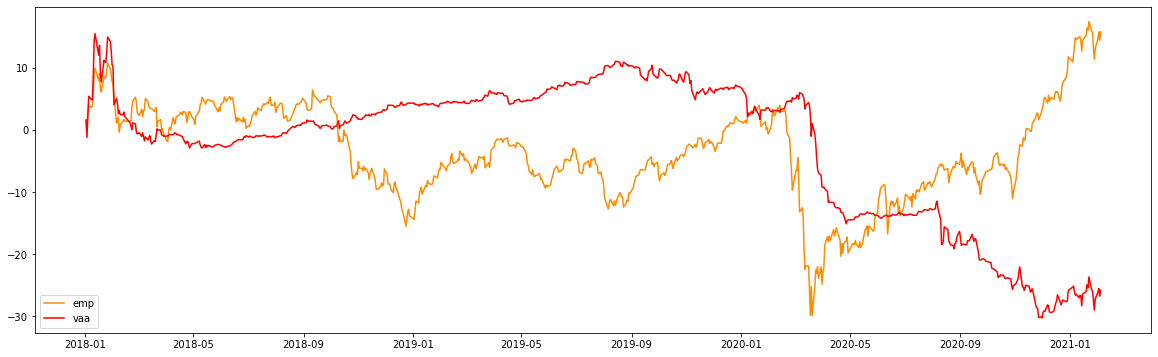

In [202]:
import matplotlib.pyplot as plt

plt.figure(figsize = (20, 6))

x_1 = emp_result["cum_return(%)"]
# x_2 = equal_result["cum_return(%)"]
x_3 = trad_vaa_result["cum_return(%)"]

plt.plot(emp_result["date"], x_1, color = 'darkorange', label = 'emp')
# plt.plot(emp_result["date"], x_2, color = '#AAAAAA', label = 'equal')
plt.plot(emp_result["date"], x_3, color = 'red', label = 'vaa')

plt.legend()
plt.show()

In [184]:
# 성과 지표 비교
all_report = pd.concat([emp_report, equal_report], axis = 1)
all_report.columns = ["EMP", "Equal"]
all_report

,EMP,Equal
cum_return,15.780,9.340
CAGR,4.850,2.929
MDD,-36.651,-41.781
SR,0.093,-0.004
Std,0.199,0.196


### 기타 자산 비교

In [129]:
# kodex200 ETF 데이터 (매수 수수료 추가)
import FinanceDataReader as fdr

kodex200_test = fdr.DataReader("143850", "2018-01-01")
kodex200_test = kodex200_test.reset_index()
kodex200_test.columns = ["date", "open", "high", "low", "close", "volume", "return"]
kodex200_test = pd.merge(kodex200_test, kospi_result["date"], on = "date", how = "inner")
kodex200_test.iloc[0,6] = kodex200_test.iloc[0,6] - 0.00015
kodex200_test.head()

,date,open,high,low,close,volume,return
0,2018-01-02,31835,31865,31750,31770,25463,-0.003444
1,2018-01-03,31935,31995,31935,31995,11717,0.007082
2,2018-01-04,32135,32210,32135,32205,4384,0.006564
3,2018-01-05,32315,32355,32310,32350,4557,0.004502
4,2018-01-08,32550,32570,32540,32560,18910,0.006491


In [130]:
# 누적 포트폴리오 수익률
new_asset = 1
cum_return = []
asset_value = []
for i in range(0, len(kodex200_test)):
    new_asset = new_asset * (1 + kodex200_test["return"][i])
    cum_r = (new_asset - 1) * 100

    cum_return.append(cum_r)
    asset_value.append(new_asset)

kodex200_test["cum_return(%)"] = cum_return
kodex200_test["asset_value"] = asset_value

kodex200_test

,date,open,high,low,close,volume,return,cum_return(%),asset_value
0,2018-01-02,31835,31865,31750,31770,25463,-0.003444,-0.344412,0.996556
1,2018-01-03,31935,31995,31935,31995,11717,0.007082,0.361364,1.003614
2,2018-01-04,32135,32210,32135,32205,4384,0.006564,1.020089,1.010201
3,2018-01-05,32315,32355,32310,32350,4557,0.004502,1.474922,1.014749
4,2018-01-08,32550,32570,32540,32560,18910,0.006491,2.133647,1.021336
...,...,...,...,...,...,...,...,...,...
736,2021-02-01,42880,43415,42860,43350,41797,-0.004478,24.405880,1.244059
737,2021-02-02,43915,44200,43835,44130,80911,0.017993,26.644324,1.266443
738,2021-02-03,44655,44745,44590,44725,56359,0.013483,28.351856,1.283519
739,2021-02-04,44690,44690,44430,44540,15469,-0.004136,27.820943,1.278209


In [131]:
portfolio_report(kodex200_test).T

,0
cum_return,27.820
CAGR,8.251
MDD,-34.991
SR,0.253
Std,0.207


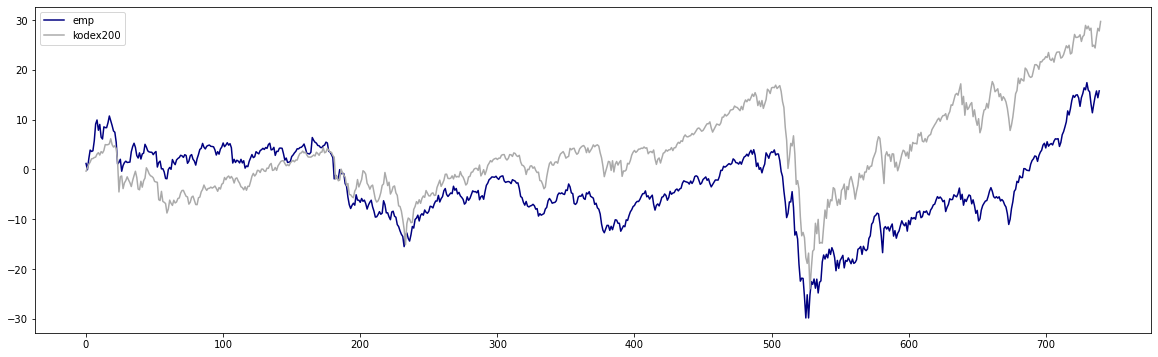

In [132]:
import matplotlib.pyplot as plt

plt.figure(figsize = (20, 6))

x_1 = emp_result["cum_return(%)"]
x_2 = kodex200_test["cum_return(%)"]

plt.plot(x_1, color = 'navy', label = 'emp')
plt.plot(x_2, color = '#AAAAAA', label = 'kodex200')

plt.legend()
plt.show()